In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Kontrola zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používám zařízení: {device}")

# Cesty k datasetu
train_dir = "dataset/train"
test_dir = "dataset/test"
valid_dir = "dataset/valid"

# Transformace pro trénink a test
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

Používám zařízení: cuda


In [3]:
# dataset classification
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_dataset.class_to_idx

# DataLoadery
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [4]:
# Dataset

# DataLoadery
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model initialization steps:
# 1. Load pre-trained ResNet18 model which was trained on ImageNet dataset
model = models.resnet18(pretrained=True)
# 2. Replace the final fully connected layer to match our binary classification task
#    - Original layer had 1000 outputs (ImageNet classes)
#    - New layer has 2 outputs (ok/defective classes)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: ok, defective
# 3. Move the model to appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trénink
epochs = 3
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

AttributeError: module 'torchvision.models' has no attribute 'c'

In [11]:
# Uložení váh modelu do souboru "model.pth"
torch.save(model.state_dict(), "model.pth")
print("Model byl úspěšně uložen.")

Model byl úspěšně uložen.


🎯 Test Accuracy: 99.58%


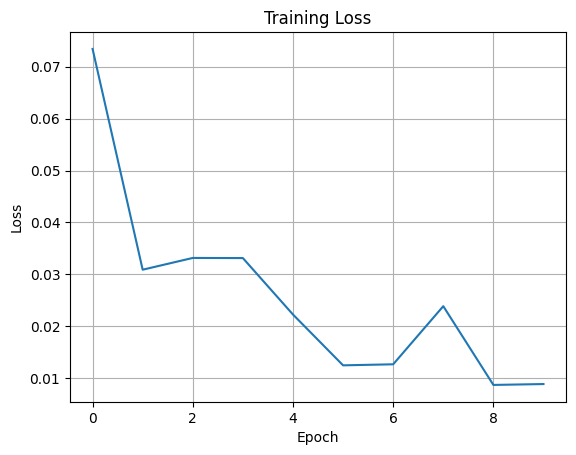

In [8]:
# Vyhodnocení přesnosti na testu
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🎯 Test Accuracy: {100 * correct / total:.2f}%")

# Vizualizace loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_34856\3674007347.py:50: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


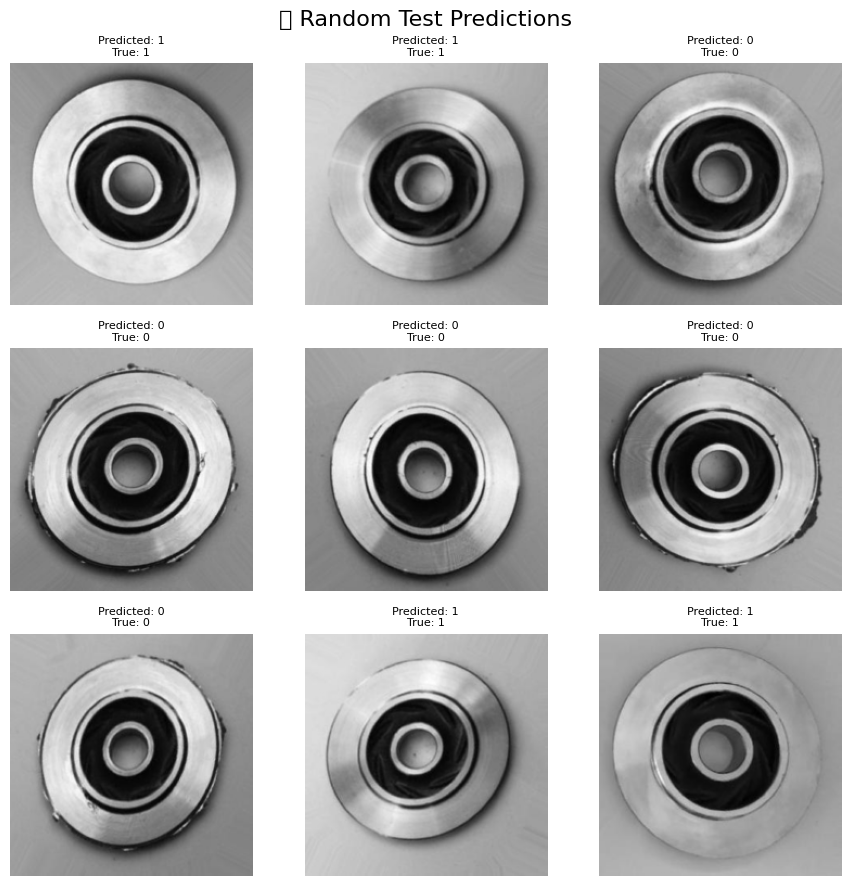

In [10]:
import matplotlib.pyplot as plt
import math
import random

# Počet obrázků k zobrazení
num_images = 9

# Získání náhodných indexů z celého datasetu
indices = random.sample(range(len(test_loader.dataset)), num_images)
samples = [test_loader.dataset[i] for i in indices]
images, labels = zip(*samples)

# Převedení na tensor batch
images = torch.stack(images)
labels = torch.tensor(labels)

# Predikce
images_gpu = images.to(device)
outputs = model(images_gpu)
_, predicted = torch.max(outputs, 1)

# Převod na CPU
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Grid setup
grid_size = int(math.ceil(math.sqrt(num_images)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
fig.suptitle("🎲 Random Test Predictions", fontsize=16)

for i in range(grid_size * grid_size):
    row = i // grid_size
    col = i % grid_size
    ax = axes[row, col]

    if i < num_images:
        img = images[i].permute(1, 2, 0)
        if img.shape[2] == 1:
            img = img.squeeze(-1)
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.set_title(f"Predicted: {predicted[i]}\nTrue: {labels[i]}", fontsize=8)
    else:
        ax.axis("off")

    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Test on images

In [9]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
import os
from PIL import Image
import numpy as np
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "model" not in globals():
    print("Model will be loaded")
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load("model.pth", map_location=device))
    model = model.to(device)
    model.eval()
    print("Model byl úspěšně načten.")

# Cesta ke složce s obrázky
IMG_DIR = "dataset/valid/"

model.eval()

# Mapa tříd
class_names = ["def", "ok"]

# Transformace
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Iterace přes obrázky
image_files = sorted(
    [f for f in os.listdir(IMG_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
)

i = 0
while i < len(image_files):
    img_path = os.path.join(IMG_DIR, image_files[i])

    # Načti obrázek pomocí PIL pro transformace
    pil_image = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Predikce
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        label = class_names[predicted.item()]
        image_result = image_files[i][5:8].split("_")[0]

    predicted_match = label == image_result
    show_only_wrong = True
    # Zobraz pomocí OpenCV
    cv_img = cv2.imread(img_path)
    text0 = f"pred:{label.upper()}"
    text1 = f"real: {image_result}"
    color = (0, 255, 0) if predicted_match else (0, 0, 255)

    cv2.putText(
        cv_img, text0, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA
    )
    cv2.putText(
        cv_img, text1, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA
    )
    cv2.imshow("Prediction", cv_img)

    print(f"image: {image_result}, predicted: {label}")

    key = cv2.waitKey(0)
    if key == ord("q"):
        break
    i += 1

cv2.destroyAllWindows()

image: def, predicted: def
